## Exercise A1: Signal Generation and Filtering
### Part 1: Generate Synthetic EEG Signal
Task: Create a synthetic signal that mimics real EEG characteristics:
Duration: 10 seconds
Sampling rate: 500 Hz
Contains: 10 Hz alpha rhythm + 50 Hz line noise + random noise


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy import signal, stats, fft

import sklearn
from sklearn import datasets, model_selection, preprocessing, metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

print("SciPy version:", scipy.__version__)
print("Scikit-learn version:", sklearn.__version__)

SciPy version: 1.15.3
Scikit-learn version: 1.6.1


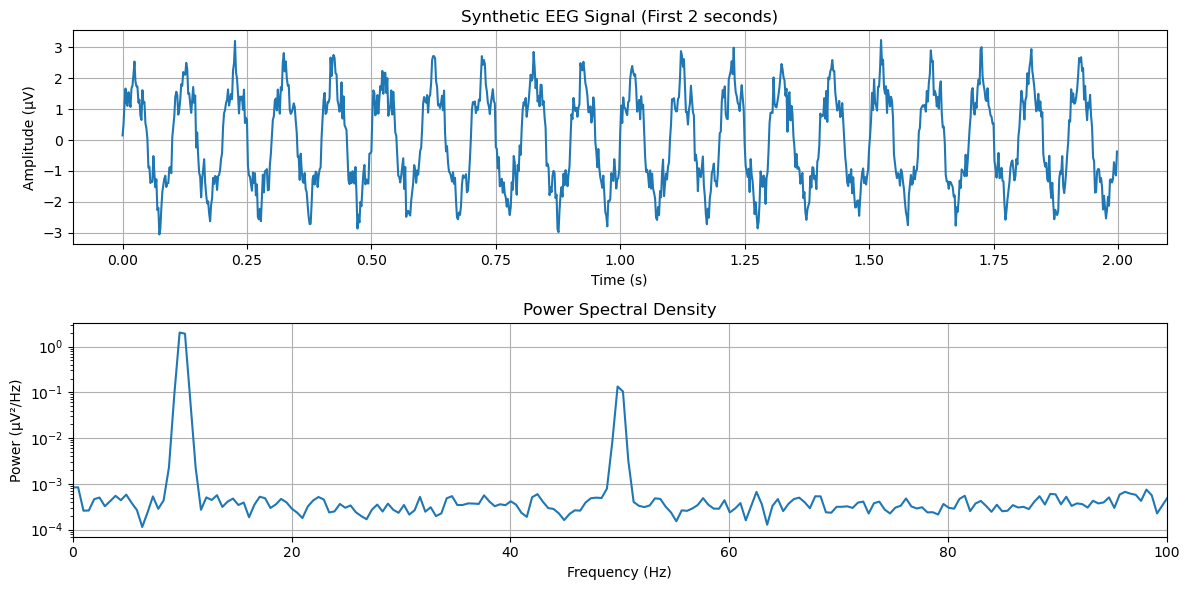

In [22]:
# Parameters
fs = 500 # Sampling frequency (Hz)
duration = 10 # Duration in seconds
t = np.linspace(0, duration, fs * duration, endpoint=False)

# Generate synthetic EEG signal
np.random.seed(42) # For reproducible results
alpha_wave = 2 * np.sin(2 * np.pi * 10 * t) # 10 Hz alpha
line_noise = 0.5 * np.sin(2 * np.pi * 50 * t) # 50 Hz line noise
random_noise = 0.3 * np.random.randn(len(t)) # Random noise
eeg_signal = alpha_wave + line_noise + random_noise

# Plot the signal
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t[:1000], eeg_signal[:1000]) # Plot first 2 seconds
plt.title('Synthetic EEG Signal (First 2 seconds)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.grid(True)

# Plot power spectral density
freqs, psd = signal.welch(eeg_signal, fs, nperseg=1024)
plt.subplot(2, 1, 2)
plt.semilogy(freqs, psd)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (μV²/Hz)')
plt.xlim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()


## Part 2: Apply Filters
### Task: Apply different types of filters to clean the signal:
1. High-pass filter (>1 Hz) to remove DC drift
2. Low-pass filter (<40 Hz) to remove high-frequency noise
3. Notch filter (50 Hz) to remove line noise
4. Band-pass filter (8-12 Hz) to isolate alpha band

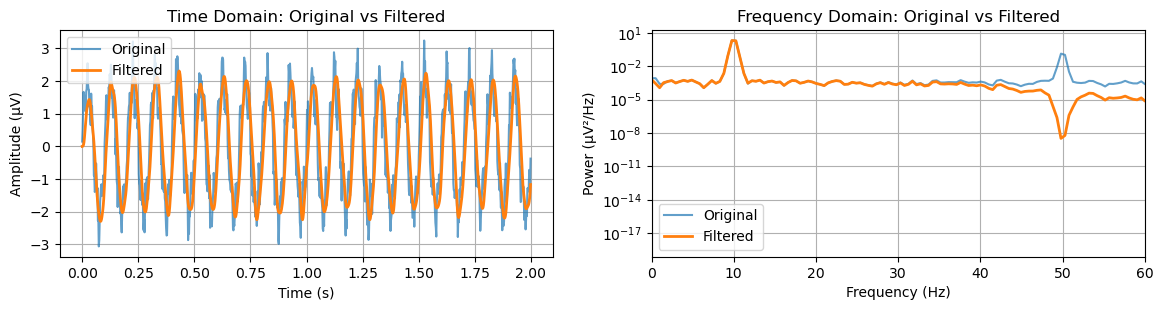

In [7]:
# 1. High-pass filter (>1 Hz)
sos_highpass = signal.butter(4, 1, btype='high', fs=fs, output='sos')
signal_hp = signal.sosfilt(sos_highpass, eeg_signal)

# 2. Low-pass filter (<40 Hz)
sos_lowpass = signal.butter(4, 40, btype='low', fs=fs, output='sos')
signal_lp = signal.sosfilt(sos_lowpass, signal_hp)

# 3. Notch filter (50 Hz ± 2 Hz)
sos_notch = signal.butter(4, [48, 52], btype='bandstop', fs=fs,
output='sos')
signal_notch = signal.sosfilt(sos_notch, signal_lp)

# 4. Band-pass filter (8-12 Hz for alpha)
sos_alpha = signal.butter(4, [8, 12], btype='band', fs=fs,
output='sos')
signal_alpha = signal.sosfilt(sos_alpha, eeg_signal)

# Compare original and filtered signals
plt.figure(figsize=(14, 10))

# Time domain comparison
plt.subplot(3, 2, 1)
plt.plot(t[:1000], eeg_signal[:1000], label='Original', alpha=0.7)
plt.plot(t[:1000], signal_notch[:1000], label='Filtered', linewidth=2)
plt.title('Time Domain: Original vs Filtered')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.legend()
plt.grid(True)

# Frequency domain comparison
freqs_orig, psd_orig = signal.welch(eeg_signal, fs, nperseg=1024)
freqs_filt, psd_filt = signal.welch(signal_notch, fs, nperseg=1024)
plt.subplot(3, 2, 2)
plt.semilogy(freqs_orig, psd_orig, label='Original', alpha=0.7)
plt.semilogy(freqs_filt, psd_filt, label='Filtered', linewidth=2)
plt.title('Frequency Domain: Original vs Filtered')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (μV²/Hz)')
plt.xlim(0, 60)
plt.legend()
plt.grid(True)

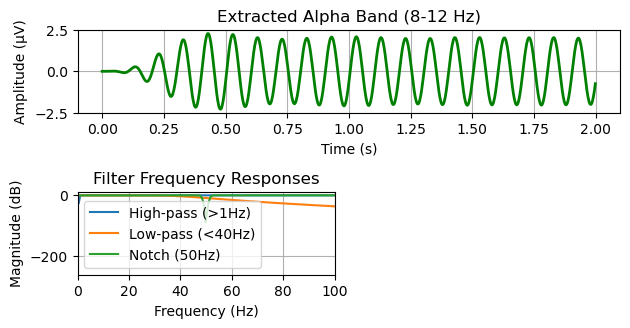

In [8]:
# Alpha band extraction
plt.subplot(3, 2, (3, 4))
plt.plot(t[:1000], signal_alpha[:1000], color='green', linewidth=2)
plt.title('Extracted Alpha Band (8-12 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.grid(True)

# Filter responses
w1, h1 = signal.sosfreqz(sos_highpass, fs=fs)
w2, h2 = signal.sosfreqz(sos_lowpass, fs=fs)
w3, h3 = signal.sosfreqz(sos_notch, fs=fs)

plt.subplot(3, 2, 5)
plt.plot(w1, 20 * np.log10(abs(h1)), label='High-pass (>1Hz)')
plt.plot(w2, 20 * np.log10(abs(h2)), label='Low-pass (<40Hz)')
plt.plot(w3, 20 * np.log10(abs(h3)), label='Notch (50Hz)')
plt.title('Filter Frequency Responses')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Exercise A2: Spectral Analysis
### Scenario: Analyze the frequency content of EEG signals using different spectral methods.
### Task:
1. Compare FFT, Welch's method, and multitaper spectral estimation
2. Compute spectrograms for time-frequency analysis
3. Calculate relative power in different frequency bands

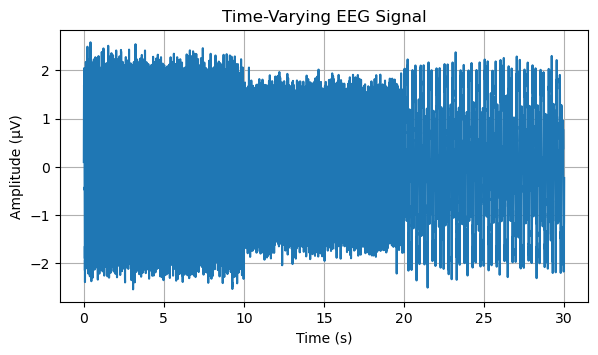

In [10]:
# Generate a more complex signal with time-varying components
t_long = np.linspace(0, 30, fs * 30, endpoint=False)
np.random.seed(42)

# Create signal with changing frequency content
signal_complex = np.zeros_like(t_long)
for i, time in enumerate(t_long):
    if time < 10:
        # First 10s: mainly alpha (10 Hz)
        signal_complex[i] = 2 * np.sin(2 * np.pi * 10 * time)
    elif time < 20:
        # Next 10s: mainly beta (20 Hz)
        signal_complex[i] = 1.5 * np.sin(2 * np.pi * 20 * time)
    else:
        # Last 10s: mixed alpha and theta (10 Hz + 6 Hz)
        signal_complex[i] = np.sin(2 * np.pi * 10 * time) + np.sin(2 *np.pi * 6 * time)


# Add consistent noise
signal_complex += 0.2 * np.random.randn(len(t_long))

# Method 1: FFT
fft_freqs = fft.fftfreq(len(signal_complex), 1/fs)
fft_power = np.abs(fft.fft(signal_complex))**2

# Method 2: Welch's method
welch_freqs, welch_power = signal.welch(signal_complex, fs,
nperseg=2048)

# Method 3: Multitaper (using scipy's implementation)
from scipy.signal import spectrogram
mt_freqs, mt_times, mt_power = spectrogram(signal_complex, fs,
nperseg=1024, noverlap=512)

# Plot comparisons
plt.figure(figsize=(15, 12))

# Time series
plt.subplot(3, 2, 1)
plt.plot(t_long, signal_complex)
plt.title('Time-Varying EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (μV)')
plt.grid(True)

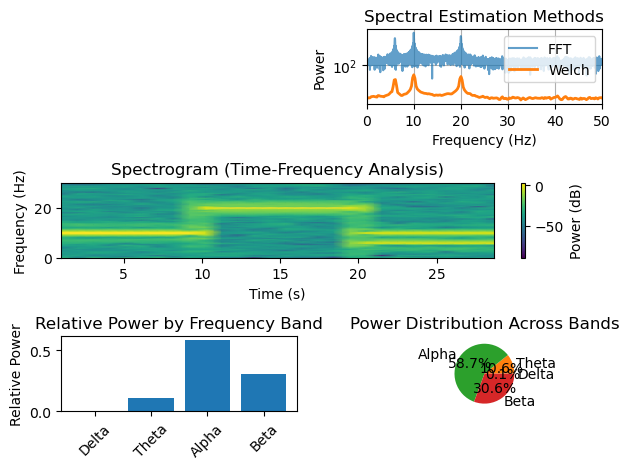

Frequency Band Analysis:
----------------------------------------
 Delta:     0.00 μV²/Hz ( 0.1%)
 Theta:     0.15 μV²/Hz (10.6%)
 Alpha:     0.82 μV²/Hz (58.7%)
  Beta:     0.43 μV²/Hz (30.6%)


In [14]:
# Spectral methods comparison
plt.subplot(3, 2, 2)
plt.semilogy(fft_freqs[:len(fft_freqs)//2],
             
fft_power[:len(fft_power)//2],
label='FFT', alpha=0.7)

plt.semilogy(welch_freqs, welch_power, label='Welch', linewidth=2)
plt.title('Spectral Estimation Methods')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.xlim(0, 50)
plt.legend()
plt.grid(True)

# Spectrogram
plt.subplot(3, 2, (3, 4))
plt.pcolormesh(mt_times, mt_freqs, 10 * np.log10(mt_power),
shading='gouraud', cmap='viridis')

plt.title('Spectrogram (Time-Frequency Analysis)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0, 30)
plt.colorbar(label='Power (dB)')

# Frequency band analysis
delta = (1, 4)
theta = (4, 8)
alpha = (8, 13)
beta = (13, 30)

bands = {'Delta': delta, 'Theta': theta, 'Alpha': alpha, 'Beta': beta}
band_powers = {}

for band_name, (low, high) in bands.items():
    band_mask = (welch_freqs >= low) & (welch_freqs <= high)
    band_powers[band_name] = np.trapz(welch_power[band_mask], welch_freqs[band_mask])

# Relative power
total_power = sum(band_powers.values())
relative_powers = {band: power/total_power for band, power in
band_powers.items()}

plt.subplot(3, 2, 5)
plt.bar(relative_powers.keys(), relative_powers.values())
plt.title('Relative Power by Frequency Band')
plt.ylabel('Relative Power')
plt.xticks(rotation=45)
plt.subplot(3, 2, 6)
plt.pie(relative_powers.values(), labels=relative_powers.keys(),
autopct='%1.1f%%')
plt.title('Power Distribution Across Bands')
plt.tight_layout()
plt.show()

# Print numerical results
print("Frequency Band Analysis:")
print("-" * 40)

for band, power in band_powers.items():
    print(f"{band:>6}: {power:8.2f} μV²/Hz ({relative_powers[band]*100:4.1f}%)")



## Section B: Scikit-learn for Machine Learning

### Common MLApplications in EEG:
1. Classification: Distinguishing different mental states, conditions, or subjects
2. Dimensionality Reduction: PCA, ICA for artifact removal and feature extraction
3. Feature Selection: Identifying the most informative EEG features
4. Clustering: Grouping similar EEG patterns or subjects


### Exercise B1: EEG Feature Extraction and Classification 
#### Scenario: Classify EEG signals into different mental states using extracted features.

#### Part 1: Generate Multi-class EEG Dataset

In [18]:
# Simulate EEG data for 3 mental states

np.random.seed(42)

n_trials = 300 # 100 trials per class
n_channels = 8
trial_length = 1000 # 2 seconds at 500 Hz
fs = 500

# Generate features for different mental states
def generate_eeg_trial(state, trial_idx):
    """Generate one EEG trial for a given mental state"""
    t = np.linspace(0, trial_length/fs, trial_length)
    trial_data = np.zeros((n_channels, trial_length))

    if state == 0: # Resting state - mainly alpha (8-12 Hz)
        for ch in range(n_channels):
            alpha_freq = np.random.uniform(8, 12)
            alpha_power = np.random.uniform(1.5, 3.0)
            trial_data[ch] = alpha_power * np.sin(2 * np.pi *alpha_freq * t)

    elif state == 1: # Attention state - mainly beta (15-25 Hz)
        for ch in range(n_channels):
            beta_freq = np.random.uniform(15, 25)
            beta_power = np.random.uniform(1.0, 2.5)
            trial_data[ch] = beta_power * np.sin(2 * np.pi * beta_freq * t)

    else: # state == 2, Meditation - mainly theta (4-8 Hz)
        for ch in range(n_channels):
            theta_freq = np.random.uniform(4, 8)
            theta_power = np.random.uniform(2.0, 4.0)
            trial_data[ch] = theta_power * np.sin(2 * np.pi * theta_freq * t)

    # Add common noise
    noise = 0.3 * np.random.randn(n_channels, trial_length)
    trial_data += noise
    
    return trial_data
    

# Generate dataset
X_raw = []
y = []
states = ['Resting', 'Attention', 'Meditation']

for state_idx in range(3):
    for trial_idx in range(100):
        trial = generate_eeg_trial(state_idx, trial_idx)
        X_raw.append(trial)
        y.append(state_idx)

X_raw = np.array(X_raw)
y = np.array(y)

print(f"Dataset shape: {X_raw.shape}")
print(f"Labels shape: {y.shape}")
print(f"Classes: {states}")
print(f"Class distribution: {np.bincount(y)}")


Dataset shape: (300, 8, 1000)
Labels shape: (300,)
Classes: ['Resting', 'Attention', 'Meditation']
Class distribution: [100 100 100]


### Part 2: Feature Extraction
#### Task: Extract meaningful features from raw EEG data for classification.

In [20]:
# Feature extraction functions

def extract_spectral_features(trial_data, fs):
    """Extract spectral features from one trial"""
    features = []
    
    # Define frequency bands
    bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 50)
    }
    
    for ch in range(trial_data.shape[0]):
        # Compute PSD
        freqs, psd = signal.welch(trial_data[ch], fs, nperseg=256)
        
        # Extract band powers
        for band_name, (low, high) in bands.items():
            band_mask = (freqs >= low) & (freqs <= high)
            band_power = np.trapz(psd[band_mask], freqs[band_mask])
            features.append(band_power)
        
        # Statistical features
        features.append(np.mean(trial_data[ch]))
        features.append(np.std(trial_data[ch]))
        features.append(np.var(trial_data[ch]))
        
        # Hjorth parameters
        diff1 = np.diff(trial_data[ch])
        diff2 = np.diff(diff1)

        activity = np.var(trial_data[ch])
        mobility = np.sqrt(np.var(diff1) / np.var(trial_data[ch]))
        complexity = np.sqrt(np.var(diff2) / np.var(diff1)) / mobility

        features.extend([activity, mobility, complexity])
        
    return np.array(features)

# Extract features for all trials
print("Extracting features...")
X_features = []

for trial_idx in range(len(X_raw)):
    features = extract_spectral_features(X_raw[trial_idx], fs)
    X_features.append(features)
    if (trial_idx + 1) % 50 == 0:
        print(f"Processed {trial_idx + 1}/{len(X_raw)} trials")

X_features = np.array(X_features)
print(f"Features shape: {X_features.shape}")

# Feature names for interpretation
feature_names = []
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
stats = ['mean', 'std', 'var', 'activity', 'mobility', 'complexity']

for ch in range(n_channels):
    for band in bands:
        feature_names.append(f'Ch{ch+1}_{band}_power')
    for stat in stats:
        feature_names.append(f'Ch{ch+1}_{stat}')

print(f"Total features per trial: {len(feature_names)}")



Extracting features...
Processed 50/300 trials
Processed 100/300 trials
Processed 150/300 trials
Processed 200/300 trials
Processed 250/300 trials
Processed 300/300 trials
Features shape: (300, 88)
Total features per trial: 88
